# UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS
### AGE, TIME OF DAY, and LOCATION analysis on the top 10 citations in Scottsdale Arizona.  I am interested in trying to identify patterns in when some demographics receive citations.

## Possible Applications:
### By undersanding when and where certain demographics are more likely to receive citation the city could be more proactive in preventing the citations in the first place . . .

### If I were a lawyer or professional providing services to people who receive and want to contest certain types of citations, where should I advertise my services so as to be most impactful?

Am I able to spot clusters of specific demographics receiving certain types of citations?  To achieve this goal I will:

1. Apply dimensionality reduction techniques to visualize the observations.
1. Apply clustering techniques to group together similar observations.

### Process

1. Subset the dataset based on **top locations** and **citations**

2. hold one constant, adjust others

For each citation:
    examine for age, location, time of day clusters

For each location:
    examine for age, time of day, citation type clusters

For each hour of the day:
    examine for age, citation type, and location clusters


for each of these find the highest silhouette score for that particular citation, location, hour of the day


### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  


I downloaded the data in September 2018, September 2019, and January 2020.  In raw format the combined dataset includes just over 56K rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [176]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [232]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [233]:
# convert column labels to lower case and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [234]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [235]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [236]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# create day of week column
citations['week_of_year'] = citations['citation_date'].dt.weekofyear

# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

In [237]:
# one citation has no age
# drop citations where age isn't provided

citations.dropna(subset=['cited_person_age'], inplace=True)

In [238]:
citations.cited_person_sex.value_counts()

M    35199
F    21220
U       14
Name: cited_person_sex, dtype: int64

In [239]:
# 14 citations have no gender
# drop citations where gender isn't binary
citations.drop(citations[citations.cited_person_sex == 'U'].index, inplace=True)

In [240]:
# verify non-binary genders have been dropped
citations.cited_person_sex.value_counts()

M    35184
F    21216
Name: cited_person_sex, dtype: int64

In [241]:
# how many rows and columns are in the dataset?
citations.shape

(56403, 26)

## DEFINE FEATURES TO PERFORM ANALYSIS ON

In [242]:
# top 10 citations
citations.charge_description.value_counts().head(10)

Speed Greater Than R&P or Posted                 13343
Expired/No Arizona Registration                   4597
Suspended/Revoked D.L.                            3382
DUI-Impaired to Slightest Degree                  2742
Failure to Control Speed to Avoid A Collision     2670
No Proof of Insurance                             2515
Drug Paraphernalia-Possess/Use                    2506
Fail to Obey Traffic Control Device               1870
Fail to Stop For Red Signal                       1532
Fail to Stop at Stop Sign                         1469
Name: charge_description, dtype: int64

In [243]:
# top 10 citations makes up over half of all citations
citations.charge_description.value_counts().head(10).sum()

36626

In [244]:
# which locations do most citations take place at?
# these are more highly dispersed than citation type
(citations.street + ' - ' + citations.street_number).value_counts().head(20)

E Camelback Rd - 7xxx                   1398
N Scottsdale Rd - 2xxx                  1167
N Scottsdale Rd - 1xxx                  1024
E Indian School Rd - 6xxx                888
N Saddlebag Tr - 4xxx                    752
N Hayden Rd - 1xxx                       721
N Pima Rd - 2xxx                         682
E Indian Bend Rd - 7xxx                  641
E Indian Pz - 7xxx                       610
E Indian School Rd - 7xxx                604
E McDowell Rd - 6xxx                     561
N Scottsdale Rd - 8xxx                   528
E McDowell Rd - 7xxx                     490
E Chaparral Rd - 7xxx                    488
E Shea Bl - 8xxx                         449
E Via Linda - 1xxx                       430
N Scottsdale Rd / E Thomas Rd -  xxx     424
E Indian School Rd - 8xxx                419
E Shea Bl - 7xxx                         397
E Shea Bl - 6xxx                         397
dtype: int64

In [245]:
# how many citations are made up of the top 50
(citations.street + ' - ' + citations.street_number).value_counts().head(50).sum()

21770

In [246]:
# create feature for specific location each citation took place at
citations['place_id'] = citations.street + ' - ' + citations.street_number

In [247]:
top_locations = list(citations.place_id.value_counts().head(50).index)

In [248]:
top_locations = list(citations.street.value_counts().head(50).index)

In [249]:
top_citations = list(citations.charge_description.value_counts().head(10).index)

In [250]:
# subset full citation dataset with only the top 20 citations by count and
# the top 50 citation locations
citations = citations[citations.charge_description.isin(top_citations) &
                     citations.street.isin(top_locations)]

In [251]:
# how many citation meet the above criteria?
citations.shape

(18247, 27)

In [252]:
# segment age into buckets
citations['age_breaks'] = pd.qcut(citations.cited_person_age, q=5)

In [253]:
citations.age_breaks.value_counts().sort_index()

(17.999, 24.0]    4431
(24.0, 29.0]      3132
(29.0, 37.0]      3395
(37.0, 50.0]      3935
(50.0, 97.0]      3354
Name: age_breaks, dtype: int64

In [254]:
citations.head()

arizona_statute_code  beat                charge_description  citation_#  \
0              28-701A  12.0  Speed Greater Than R&P or Posted     8096915   
1              28-701A  12.0  Speed Greater Than R&P or Posted     8096916   
2              28-701A   7.0  Speed Greater Than R&P or Posted     8096917   
3              28-701A   7.0  Speed Greater Than R&P or Posted     8096918   
4              28-701A  19.0  Speed Greater Than R&P or Posted     8095091   

  citation_date  citation_time citation_type_code citation_type_description  \
0    2019-07-10            747                 CV             Civil Traffic   
1    2019-07-10            800                 CV             Civil Traffic   
2    2019-07-10            853                 CV             Civil Traffic   
3    2019-07-11            843                 CV             Civil Traffic   
4    2019-07-06           2215                 CV             Civil Traffic   

             cited_person  cited_person_age cited_person_ethnicity  \
0     Hansen, Christopher              19.0                      N   
1            Koch, JOshua              36.0                      N   
2             Dahl, Renee              61.0                      N   
3                Lu, Hung              59.0                      N   
4  Noller-Johnson, Aarron              23.0                      U   

  cited_person_race cited_person_sex        city district   officer_badge_#  \
0                 W                M  Scottsdale       D3  1335               
1                 W                M  Scottsdale       D3  1335               
2                 W                F  Scottsdale       D2  1335               
3                 A                M  Scottsdale       D2  1335               
4                 W                M  Scottsdale       D4  1450               

  state          street street_number  zip  zone  tcmainid  month  \
0    AZ       E Shea Bl          6xxx  NaN  3003    662799      7   
1    AZ       E Shea Bl          6xxx  NaN  3003    662801      7   
2    AZ  N Goldwater Bl          4xxx  NaN  1102    662802      7   
3    AZ  N Goldwater Bl          4xxx  NaN  1102    662804      7   
4    AZ       N Pima Rd          2xxx  NaN  3801    662805      7   

   day_of_week  week_of_year  hour_of_day               place_id  \
0            2            28            7       E Shea Bl - 6xxx   
1            2            28            8       E Shea Bl - 6xxx   
2            2            28            8  N Goldwater Bl - 4xxx   
3            3            28            8  N Goldwater Bl - 4xxx   
4            5            27           22       N Pima Rd - 2xxx   

       age_breaks  
0  (17.999, 24.0]  
1    (29.0, 37.0]  
2    (50.0, 97.0]  
3    (50.0, 97.0]  
4  (17.999, 24.0]

In [255]:
# combine columns and send to CSV
pd.concat([citations[['cited_person_age',
                    'citation_time',
                    'charge_description',
                     'street']], 
             citations.iloc[:,-6:]], axis=1).to_csv('clustering_features.csv', index=False)

In [136]:
# assign X and y values
X = pd.get_dummies(citations[['age_breaks',
                    'citation_time', 
                    'day_of_week',
                    'place_id']])

y = citations['charge_description'].astype('category').cat.codes

In [137]:
X.head()

citation_time  day_of_week  age_breaks_(17.999, 23.0]  \
0             747            2                          1   
1             800            2                          0   
4            2215            5                          1   
6            1933            5                          0   
14           2051            5                          0   

    age_breaks_(23.0, 29.0]  age_breaks_(29.0, 37.0]  age_breaks_(37.0, 49.0]  \
0                         0                        0                        0   
1                         0                        1                        0   
4                         0                        0                        0   
6                         0                        0                        0   
14                        0                        0                        0   

    age_breaks_(49.0, 97.0]  place_id_E Cactus Rd - 7xxx  \
0                         0                            0   
1                         0                            0   
4                         0                            0   
6                         1                            0   
14                        1                            0   

    place_id_E Camelback Rd - 6xxx  place_id_E Camelback Rd - 7xxx  \
0                                0                               0   
1                                0                               0   
4                                0                               0   
6                                0                               0   
14                               0                               0   

    place_id_E Camelback Rd / N Saddlebag Tr -  xxx  \
0                                                 0   
1                                                 0   
4                                                 0   
6                                                 0   
14                                                0   

    place_id_E Camelback Rd / N Scottsdale Rd -  xxx  \
0                                                  0   
1                                                  0   
4                                                  0   
6                                                  0   
14                                                 0   

    place_id_E Chaparral Rd - 7xxx  \
0                                0   
1                                0   
4                                0   
6                                0   
14                               0   

    place_id_E Frank Lloyd Wright Bl / L101 -  xxx  \
0                                                0   
1                                                0   
4                                                0   
6                                                0   
14                                               0   

    place_id_E Frank Lloyd Wright Bl / N Hayden Rd -  xxx  \
0                                                   0       
1                                                   0       
4                                                   0       
6                                                   0       
14                                                  0       

    place_id_E Frank Lloyd Wright Bl / N Scottsdale Rd -  xxx  \
0                                                   0           
1                                                   0           
4                                                   0           
6                                                   0           
14                                                  0           

    place_id_E Indian Bend Rd - 7xxx  place_id_E Indian Pz - 7xxx  \
0                                  0                            0   
1                                  0                            0   
4                                  0                            0   
6                                  0                            0   
14                                 0       

In [138]:
X.shape

(13301, 57)

In [139]:
y.value_counts()

8    6234
2    1466
0    1126
9    1058
1     955
6     809
7     788
3     533
4     316
5      16
dtype: int64

## VISUALIZE CLUSTERS

In [140]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### PCA

In [141]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

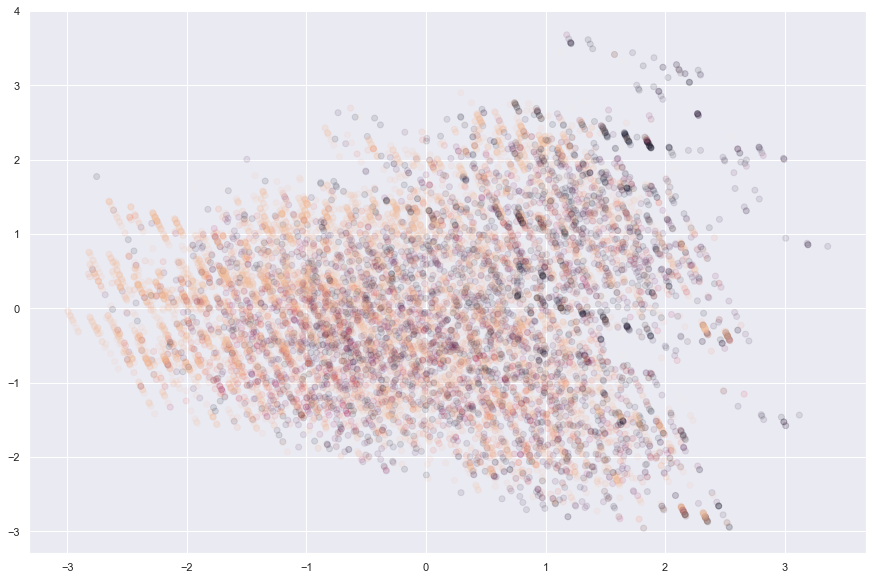

In [142]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.1)

### t-SNE

In [143]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13301 samples in 0.271s...
[t-SNE] Computed neighbors for 13301 samples in 11.791s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13301
[t-SNE] Computed conditional probabilities for sample 2000 / 13301
[t-SNE] Computed conditional probabilities for sample 3000 / 13301
[t-SNE] Computed conditional probabilities for sample 4000 / 13301
[t-SNE] Computed conditional probabilities for sample 5000 / 13301
[t-SNE] Computed conditional probabilities for sample 6000 / 13301
[t-SNE] Computed conditional probabilities for sample 7000 / 13301
[t-SNE] Computed conditional probabilities for sample 8000 / 13301
[t-SNE] Computed conditional probabilities for sample 9000 / 13301
[t-SNE] Computed conditional probabilities for sample 10000 / 13301
[t-SNE] Computed conditional probabilities for sample 11000 / 13301
[t-SNE] Computed conditional probabilities for sample 12000 / 13301
[t-SNE] Computed conditional probabilities for s

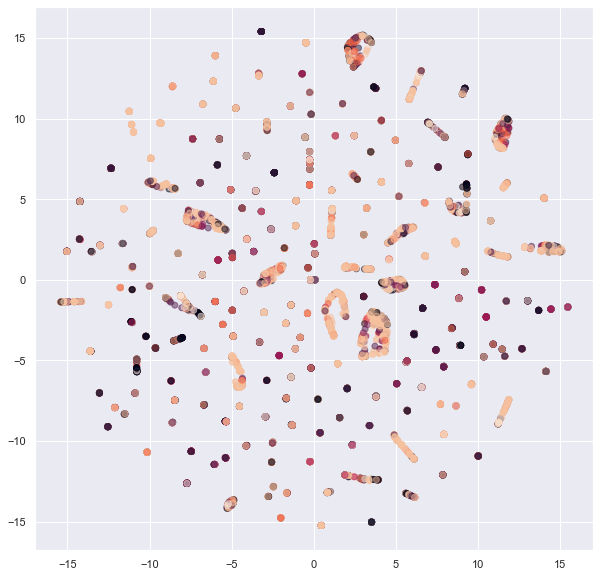

In [144]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=y)

### UMAP - iteration 1

In [145]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

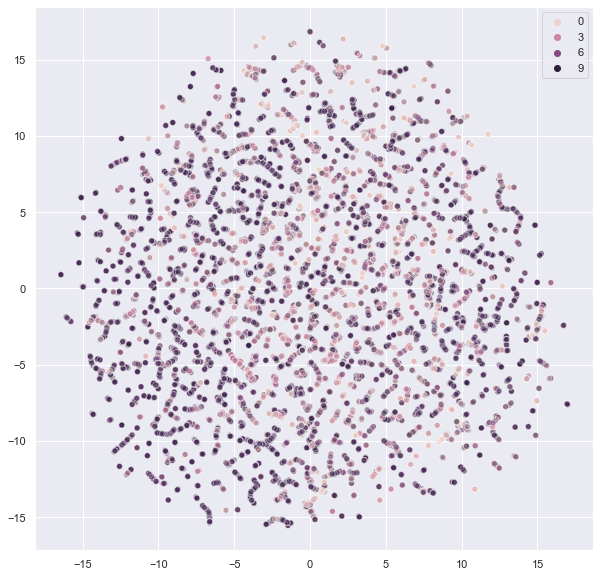

In [146]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=y)
plt.legend(loc='best')

### UMAP - iteration 2

In [147]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

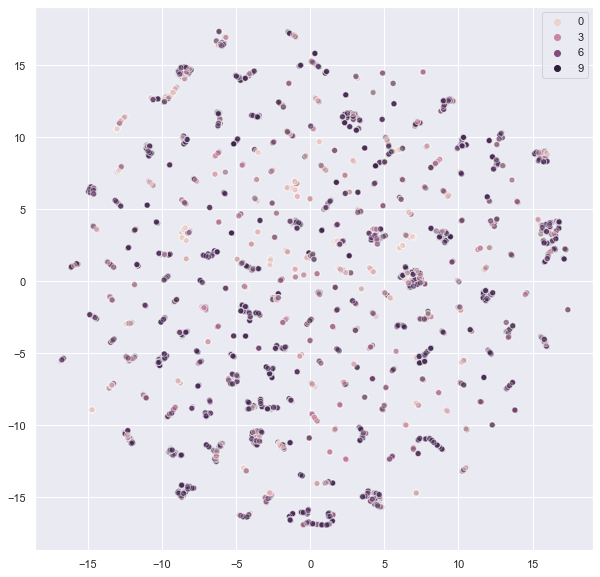

In [148]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=y)
plt.legend(loc='best')

Visually, no clear clusters based on citation type seem to be present.

## GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS

In [150]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means

In [151]:
# silhouette
labels = KMeans().fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.057

In [152]:
# ARI
y_pred = KMeans().fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.015

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [153]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [154]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.067

In [155]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

-0.056

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [156]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [157]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

-0.049

In [158]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

-0.032

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [159]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [160]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

-0.049

In [161]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

-0.032

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [162]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [163]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.055

In [164]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.025

## tied

In [165]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [166]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.056

In [167]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.017

## diag

In [168]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [169]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.055

In [170]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.025

## spherical

In [171]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [172]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.044

In [173]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.075

## COMPARE/CONTRAST DIFFERENT MODELS

In [174]:
results_df

ARI silhouette
hierarchical - ward      0.067     -0.056
hierarchical - complete -0.049     -0.032
hierarchical - average  -0.049     -0.032
k-means                  0.015      0.057
gaussian - full          0.025      0.055
gaussian - tied          0.017      0.056
gaussian - diag          0.025      0.055
gaussian - spherical     0.075      0.044

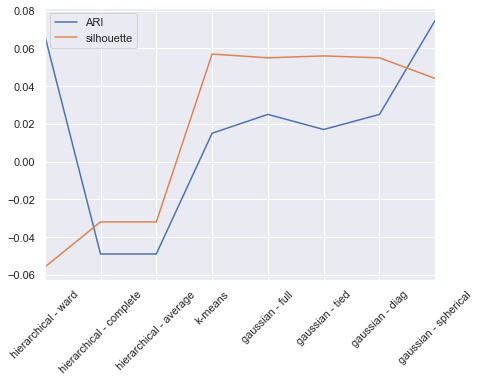

In [175]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

Focus on clustering methods that performed the best.

## 1. gaussian - tied
### iterate over different cluster sizes sice it performed the best above based on silhouette score

In [165]:
cluster_number = []
ari_score = []
silhouette_score = []

for i in range(3, 10, 1):
    cluster_number.append(i)
   
    # Fit model
    gmm_cluster = GaussianMixture(n_components=i, covariance_type='tied')
    y_pred = gmm_cluster.fit_predict(X_std)
    
    # generate scores
    ari_score.append(round(metrics.adjusted_rand_score(y, y_pred), 3))
    silhouette_score.append(round(metrics.silhouette_score(X_std, y_pred, metric='euclidean'), 3))

In [194]:
pd.DataFrame(data= {'ARI': ari_score,
                      'Silhouette': silhouette_score},
            index=cluster_number)

ARI  Silhouette
3  0.059       0.308
4  0.064       0.326
5  0.062       0.323
6  0.050       0.315
7  0.087       0.303
8  0.088       0.297
9  0.086       0.299

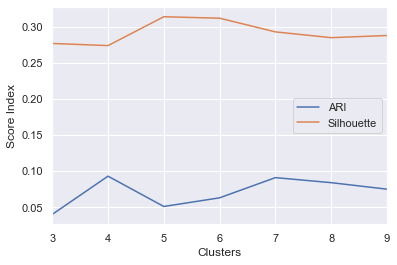

In [166]:
pd.DataFrame(data= {'ARI': ari_score,
                      'Silhouette': silhouette_score},
            index=cluster_number).plot()
plt.ylabel('Score Index')
plt.xlabel('Clusters');

It looks like 5 clusters is the best.  Which makes sense because I have included 5 different citation types in the dataset.

In [181]:
# Fit model at 5 clusters
gmm_cluster = GaussianMixture(n_components=5, covariance_type='tied')
labels = gmm_cluster.fit_predict(X_std)

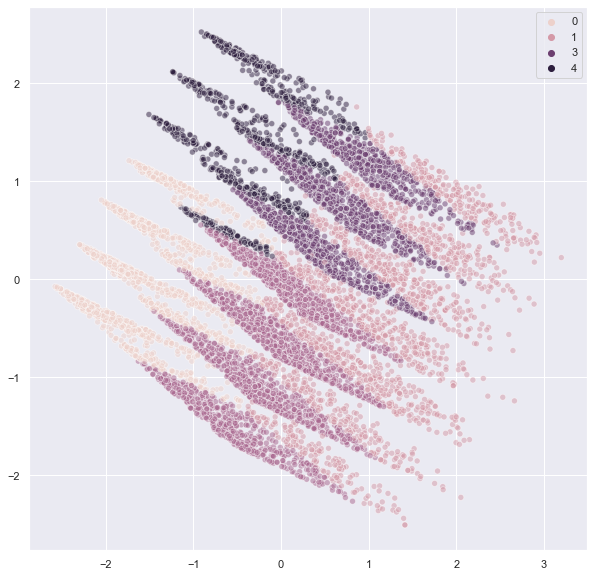

In [182]:
plt.figure(figsize=(10,10))

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=labels, alpha=.5)

### t-SNE

In [183]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.005s...
[t-SNE] Computed neighbors for 8784 samples in 0.269s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 0.163397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.674034
[t-SNE] KL divergence after 300 iterations: 1.909406


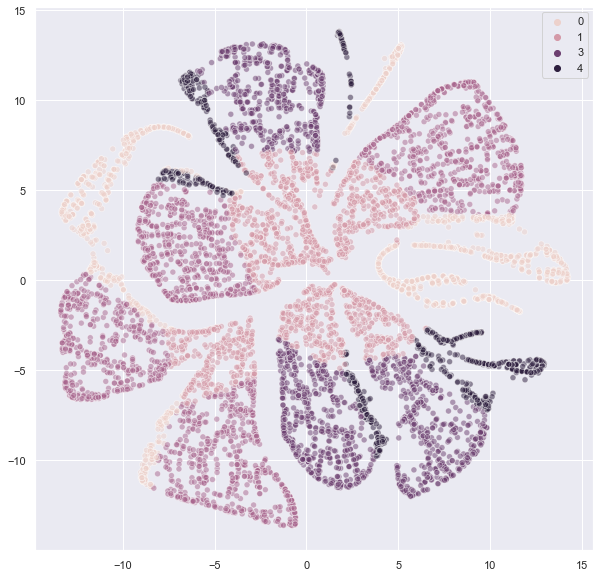

In [184]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, hue=labels)

### UMAP - iteration 1

In [185]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

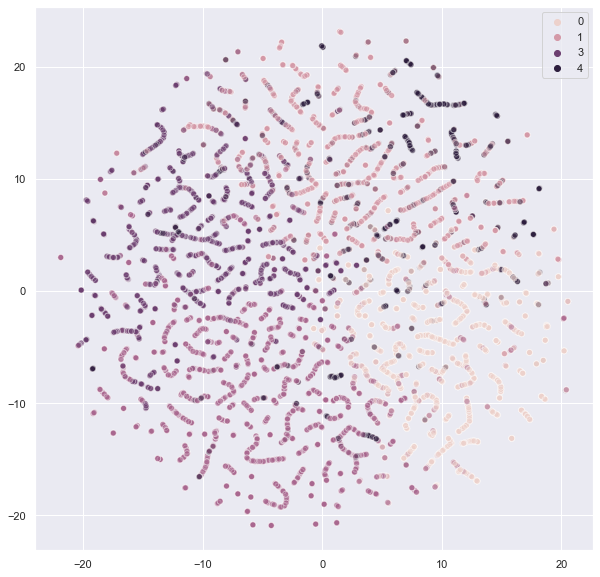

In [186]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 2

In [187]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

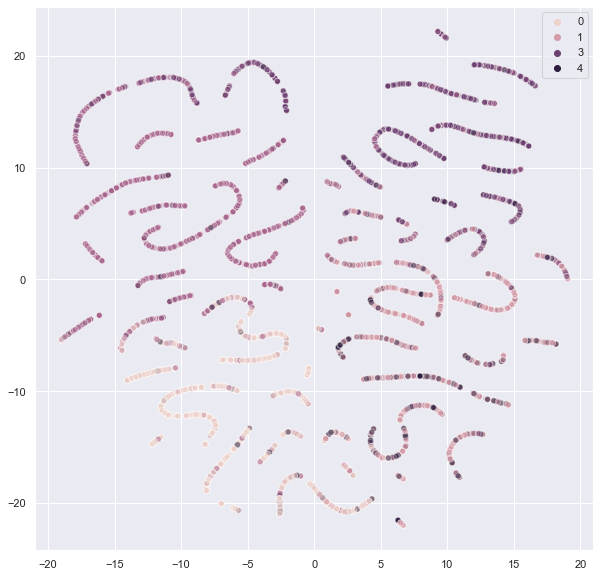

In [188]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 3

In [189]:
umap_results = umap.UMAP(n_neighbors=100,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

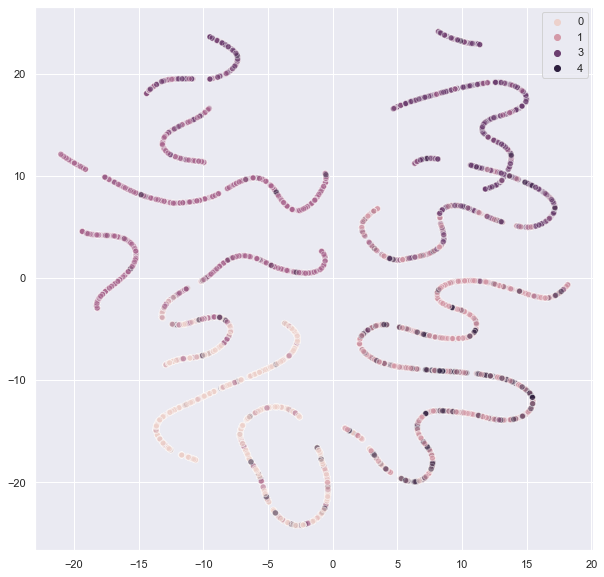

In [190]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 4

In [191]:
umap_results = umap.UMAP(n_neighbors=500,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

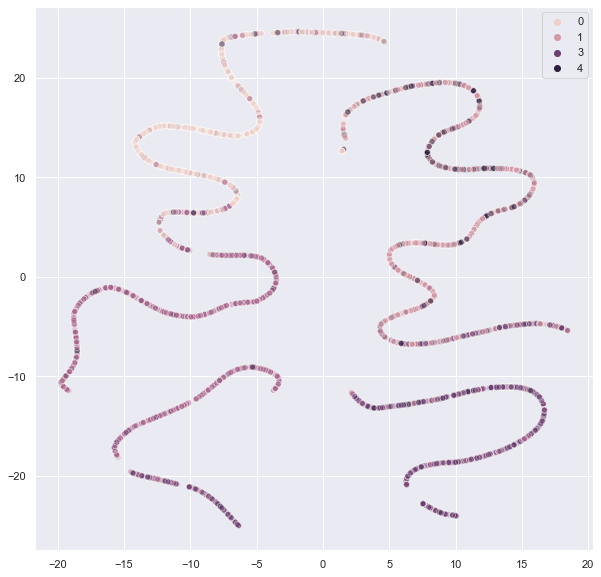

In [192]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

## 2. k-means 
### iterate over different cluster sizes sice it performed the 2nd best above based on silhouette and the best based on ARI scores

In [167]:
cluster_number = []
ari_score = []
silhouette_score = []

for i in range(3, 10, 1):
    cluster_number.append(i)
   
    # Fit model
    y_pred = KMeans(n_clusters=i).fit_predict(X_std)
    
    # generate scores
    ari_score.append(round(metrics.adjusted_rand_score(y, y_pred), 3))
    silhouette_score.append(round(metrics.silhouette_score(X_std, y_pred, metric='euclidean'), 3))

In [193]:
pd.DataFrame(data= {'ARI': ari_score,
                      'Silhouette': silhouette_score},
            index=cluster_number)

ARI  Silhouette
3  0.059       0.308
4  0.064       0.326
5  0.062       0.323
6  0.050       0.315
7  0.087       0.303
8  0.088       0.297
9  0.086       0.299

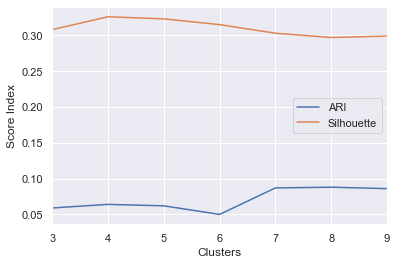

In [168]:
pd.DataFrame(data= {'ARI': ari_score,
                      'Silhouette': silhouette_score},
            index=cluster_number).plot()
plt.ylabel('Score Index')
plt.xlabel('Clusters');

It looks like 5 clusters is the best fit

## Visualize K-means at 5 clusters

In [169]:
labels = KMeans(n_clusters=5).fit_predict(X_std)

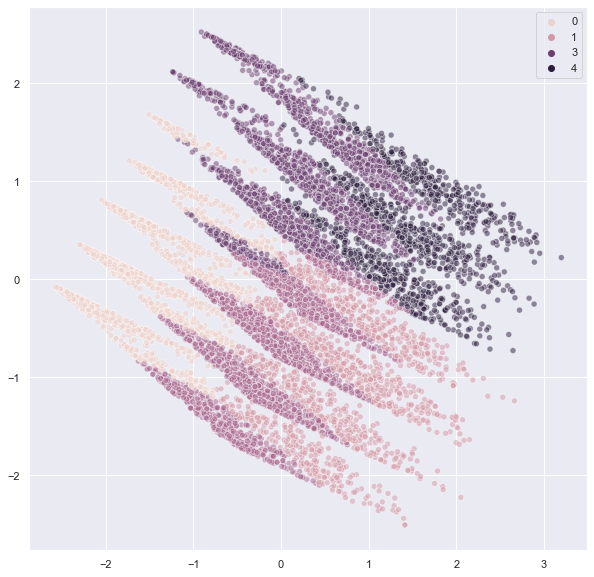

In [170]:
plt.figure(figsize=(10,10))

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=labels, alpha=.5)

### t-SNE

In [171]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.004s...
[t-SNE] Computed neighbors for 8784 samples in 0.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 0.163397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.975780
[t-SNE] KL divergence after 300 iterations: 1.885465


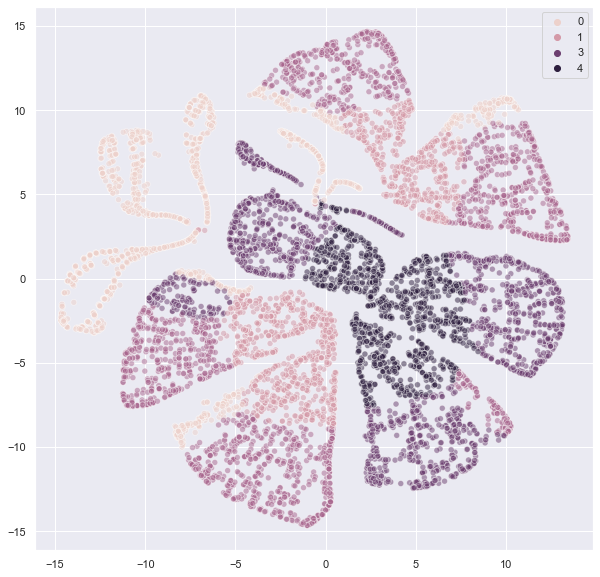

In [172]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, hue=labels)

### UMAP - iteration 1

In [173]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

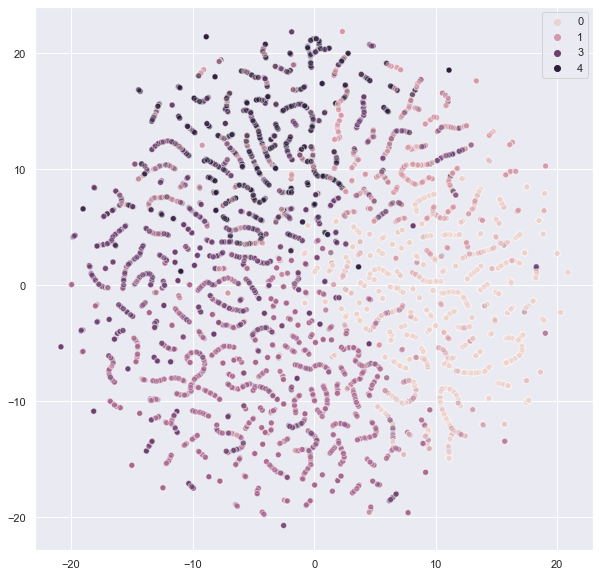

In [174]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 2

In [175]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

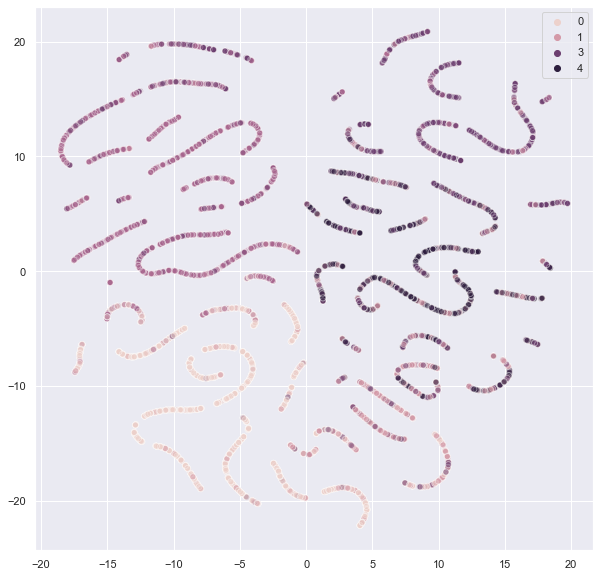

In [176]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 3

In [177]:
umap_results = umap.UMAP(n_neighbors=100,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

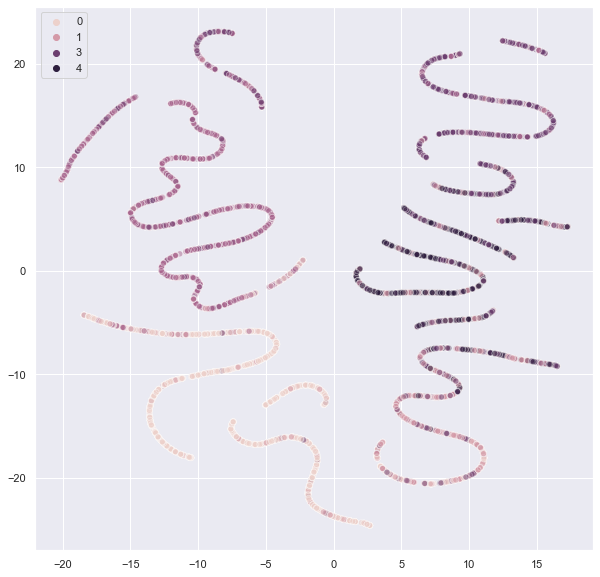

In [178]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

### UMAP - iteration 4

In [179]:
umap_results = umap.UMAP(n_neighbors=500,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

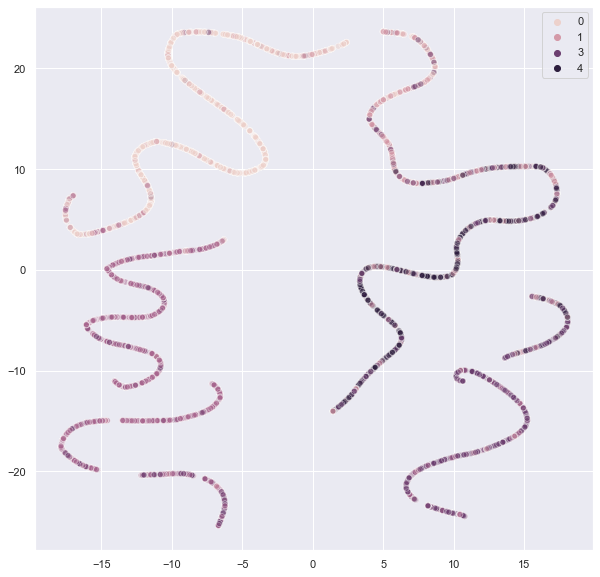

In [180]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.5, hue=labels)
plt.legend(loc='best')

## Summary:

### Based on silhouette score, the best performing models were gausian('tied') and k-means, each set at 5 clusters.  Based on ARI score the best performing clustering model was k-means.  This is what I would expect since I included 5 different types of citations in the data I used to perform the clustering analysis.

### After tuning the models and adjusting hyperparameters, by visual inspection specific clusters making up the citations are present.  The clusters are most visible using t-SNE and PCA. 

### When I first performed the analysis I included the gender of the person who received the citation.  This seemed to only make it harder for the clustering models to define the contours of the clusters.  When I removed the gender feature, the clusters became much more visible.

## Appendix:

### Examine clusters using DBSCAN - after tuning paramaters for DBSCAN, it was not successful at identifying an optimal cluster number for my dataset.

### Iteration 1

In [155]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [156]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [157]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

min_samples  eps
1             1    1
2             1    1
3             1    1
4             1    1
5             1    1
6             1    1
7             1    1
8             1    1
9             1    1
10            1    1

Text(0, 0.5, 'Clusters')

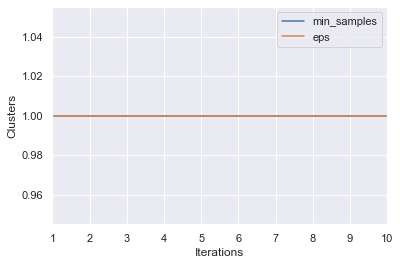

In [158]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')

### Iteration 2

In [159]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,101,10):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [160]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,101,10):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [161]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

min_samples  eps
1             1    1
2             1    1
3             1    1
4             1    1
5             1    1
6             1    1
7             1    1
8             1    1
9             1    1
10            1    1

Text(0, 0.5, 'Clusters')

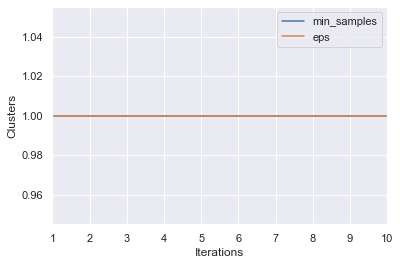

In [162]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')

### HDBSCAN - this kept giving me an error I couldn't resovle

In [189]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [179]:
clusterer

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=False)

In [198]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

IndexError: list index out of range

In [196]:
zip(pd.Series(clusterer.probabilities_), pd.Series(clusterer.labels_))

In [194]:
pd.Series(clusterer.labels_).shape

(13301,)

In [187]:
plt.scatter(test_data.T[0], test_data.T[1], c=pd.Series(clusterer.labels_), **plot_kwds)

NameError: name 'test_data' is not defined

In [ ]:
pd.Series(clusterer.labels_)

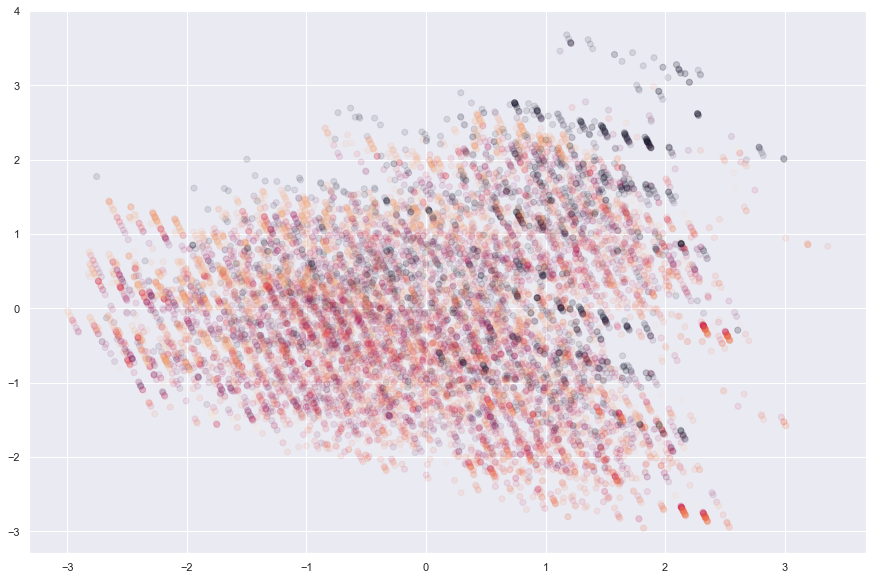

In [188]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusterer.labels_), alpha=.1)

In [199]:
# segment ages of people who receive citations
age_breaks = jenkspy.jenks_breaks(citations.cited_person_age, 
                                  nb_class=5)

KeyError: 2